# Solution overview
This solution implements three local search algorithms—steepest-ascent hill-climbing, simulated annealing, and genetic algorithms—to optimize the placement of 20 storage racks in a 20×20 warehouse grid. All algorithms minimize the objective function:

Key components:

RackState encapsulates rack placement state, the objective function, and neighborhood generation (moving one rack by ±1 in x or y).
Hill-climbing greedily moves to the best neighboring state until a local minimum is reached.
Simulated annealing probabilistically accepts worse moves early (high temperature) and becomes greedy as temperature cools, allowing escape from local minima.
Genetic algorithm maintains a population and evolves it through tournament selection, single-point crossover, and mutation over multiple generations.
The comparison script runs all three algorithms on 20 random initial states, tracks convergence histories, aggregates statistics, and visualizes the final layouts.

In [1]:
# Verify required packages are available
import sys
print(f"Python version: {sys.version}")

try:
    import numpy as np
    print(f"✓ numpy {np.__version__} is available")
except ImportError as e:
    print(f"✗ numpy not available: {e}")

try:
    import matplotlib.pyplot as plt
    print("✓ matplotlib is available")
except ImportError as e:
    print(f"✗ matplotlib not available: {e}")

print("All required packages are ready!")

Python version: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.6.3.2)]
✓ numpy 2.4.1 is available
✓ matplotlib is available
All required packages are ready!


In [2]:
"""
Warehouse storage rack placement environment.
Manages state representation, objective function, and neighborhood generation
for optimizing the placement of 20 storage racks in a 20x20 warehouse grid.
"""
import random
from typing import List, Tuple
import numpy as np
class RackState:
    """Represents the placement of 20 storage racks in a 20x20 warehouse."""
    GRID_SIZE = 20
    NUM_RACKS = 20
    DEPOT = (10, 10)
    CONGESTION_THRESHOLD = 5
    CONGESTION_WEIGHT = 2.0
    def __init__(self, positions: List[Tuple[int, int]] = None):
        """
        Initialize a rack placement state.
        Args:
            positions: List of (x, y) tuples representing rack positions.
                      If None, generates random placement.
        """
        if positions is None:
            self.positions = self._generate_random_placement()
        else:
            self.positions = list(set(positions))  # Ensure uniqueness
            if len(self.positions) != self.NUM_RACKS:
                raise ValueError(
                    f"Must have exactly {self.NUM_RACKS} unique positions"
                )
    def _generate_random_placement(self) -> List[Tuple[int, int]]:
        """Generate a random valid placement of racks."""
        positions = set()
        while len(positions) < self.NUM_RACKS:
            x = random.randint(0, self.GRID_SIZE - 1)
            y = random.randint(0, self.GRID_SIZE - 1)
            # Avoid placing racks at depot
            if (x, y) != self.DEPOT:
                positions.add((x, y))
        return sorted(list(positions))
    @staticmethod
    def manhattan_distance(pos1: Tuple[int, int],
                          pos2: Tuple[int, int]) -> int:
        """Compute Manhattan distance between two positions."""
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])
    def objective_function(self) -> float:
        """
        Compute the objective function value.
        f(s) = (1/20) * sum(distances from depot) + 2.0 * congestion_count
        Returns:
            float: Objective value to minimize.
        """
        # Average travel distance to depot
        total_distance = sum(
            self.manhattan_distance(self.DEPOT, pos)
            for pos in self.positions
        )
        avg_distance = total_distance / self.NUM_RACKS
        # Congestion penalty: count racks within distance threshold of depot
        congestion_count = sum(
            1 for pos in self.positions
            if self.manhattan_distance(self.DEPOT, pos) < self.CONGESTION_THRESHOLD
        )
        congestion_penalty = self.CONGESTION_WEIGHT * congestion_count
        return avg_distance + congestion_penalty
    def get_neighbors(self) -> List['RackState']:
        """
        Generate all neighbors by moving one rack by ±1 in x or y.
        Returns:
            List of neighboring RackState objects.
        """
        neighbors = []
        for i, (x, y) in enumerate(self.positions):
            # Try all four directions
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                new_x = x + dx
                new_y = y + dy
                # Check bounds
                if not (0 <= new_x < self.GRID_SIZE and
                        0 <= new_y < self.GRID_SIZE):
                    continue
                # Check not at depot
                if (new_x, new_y) == self.DEPOT:
                    continue
                # Check uniqueness
                new_pos = (new_x, new_y)
                if new_pos in self.positions:
                    continue
                # Create neighbor
                neighbor_positions = self.positions.copy()
                neighbor_positions[i] = new_pos
                neighbors.append(RackState(neighbor_positions))
        return neighbors
    def copy(self) -> 'RackState':
        """Create a deep copy of this state."""
        return RackState(self.positions.copy())
    def to_grid(self) -> np.ndarray:
        """
        Convert to a 2D grid representation.
        Returns:
            20x20 array where 1 = rack, 2 = depot, 0 = empty.
        """
        grid = np.zeros((self.GRID_SIZE, self.GRID_SIZE), dtype=int)
        for x, y in self.positions:
            grid[y, x] = 1
        grid[self.DEPOT[1], self.DEPOT[0]] = 2
        return grid
    def __repr__(self) -> str:
        return f"RackState(obj={self.objective_function():.2f})"

In [5]:
"""
Visualization utilities for warehouse rack placement.
Provides functions to plot convergence curves and final rack layouts.
"""
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from typing import Dict, List, Tuple

# Note: RackState class is defined in the previous cell
class RackVisualizer:
    """Handles visualization of rack placement solutions."""
    @staticmethod
    def plot_convergence(history_dict: Dict[str, List[float]],
                        figsize: Tuple[int, int] = (10, 6)):
        """
        Plot convergence curves for multiple algorithms.
        Args:
            history_dict: Dictionary mapping algorithm name to list of objective values.
            figsize: Figure size tuple (width, height).
        """
        plt.figure(figsize=figsize)
        for algorithm_name, history in history_dict.items():
            plt.plot(history, linewidth=2, label=algorithm_name, alpha=0.8)
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Objective Function Value', fontsize=12)
        plt.title('Convergence Curves')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        return plt.gcf()
    @staticmethod
    def plot_layout(state: RackState, title: str = "Rack Placement Layout",
                   figsize: Tuple[int, int] = (8, 8)):
        """
        Plot the warehouse layout with racks and depot.
        Args:
            state: RackState object to visualize.
            title: Plot title.
            figsize: Figure size tuple.
        """
        fig, ax = plt.subplots(figsize=figsize)
        # Draw grid
        ax.set_xlim(-0.5, RackState.GRID_SIZE - 0.5)
        ax.set_ylim(-0.5, RackState.GRID_SIZE - 0.5)
        ax.set_aspect('equal')
        # Grid lines
        for i in range(RackState.GRID_SIZE + 1):
            ax.axhline(y=i - 0.5, color='lightgray', linewidth=0.5)
            ax.axvline(x=i - 0.5, color='lightgray', linewidth=0.5)
        # Draw depot
        depot_circle = patches.Circle(RackState.DEPOT, 0.3,
                                     color='red', zorder=10, label='Depot')
        ax.add_patch(depot_circle)
        # Draw congestion zone (distance < 5 from depot)
        for x in range(RackState.GRID_SIZE):
            for y in range(RackState.GRID_SIZE):
                dist = RackState.manhattan_distance(RackState.DEPOT, (x, y))
                if dist < RackState.CONGESTION_THRESHOLD and (x, y) != RackState.DEPOT:
                    rect = patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                           linewidth=0, facecolor='yellow', alpha=0.2)
                    ax.add_patch(rect)
        # Draw racks
        for x, y in state.positions:
            rect = patches.Rectangle((x - 0.4, y - 0.4), 0.8, 0.8,
                                    linewidth=1, edgecolor='blue',
                                    facecolor='lightblue', zorder=5)
            ax.add_patch(rect)
        ax.set_xlabel('X Position', fontsize=11)
        ax.set_ylabel('Y Position', fontsize=11)
        ax.set_title(f"{title}\nObjective: {state.objective_function():.2f}",
                    fontsize=12, fontweight='bold')
        ax.legend(['Depot', 'Racks', 'Congestion Zone'], loc='upper right', fontsize=10)
        plt.tight_layout()
        return fig
    @staticmethod
    def plot_comparison_layouts(solutions_dict: Dict[str, RackState],
                               figsize: Tuple[int, int] = (15, 5)):
        """
        Plot final layouts from multiple algorithms side by side.
        Args:
            solutions_dict: Dictionary mapping algorithm name to best RackState.
            figsize: Figure size tuple.
        """
        num_algorithms = len(solutions_dict)
        fig, axes = plt.subplots(1, num_algorithms, figsize=figsize)
        if num_algorithms == 1:
            axes = [axes]
        for ax, (algorithm_name, state) in zip(axes, solutions_dict.items()):
            # Draw grid
            ax.set_xlim(-0.5, RackState.GRID_SIZE - 0.5)
            ax.set_ylim(-0.5, RackState.GRID_SIZE - 0.5)
            ax.set_aspect('equal')
            # Grid lines
            for i in range(RackState.GRID_SIZE + 1):
                ax.axhline(y=i - 0.5, color='lightgray', linewidth=0.5)
                ax.axvline(x=i - 0.5, color='lightgray', linewidth=0.5)
            # Draw depot
            depot_circle = patches.Circle(RackState.DEPOT, 0.3,
                                         color='red', zorder=10)
            ax.add_patch(depot_circle)
            # Draw congestion zone
            for x in range(RackState.GRID_SIZE):
                for y in range(RackState.GRID_SIZE):
                    dist = RackState.manhattan_distance(RackState.DEPOT, (x, y))
                    if dist < RackState.CONGESTION_THRESHOLD and (x, y) != RackState.DEPOT:
                        rect = patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                               linewidth=0, facecolor='yellow', alpha=0.2)
                        ax.add_patch(rect)
            # Draw racks
            for x, y in state.positions:
                rect = patches.Rectangle((x - 0.4, y - 0.4), 0.8, 0.8,
                                        linewidth=1, edgecolor='blue',
                                        facecolor='lightblue', zorder=5)
                ax.add_patch(rect)
            ax.set_xlabel('X Position', fontsize=10)
            ax.set_ylabel('Y Position', fontsize=10)
            ax.set_title(f"{algorithm_name}\nObj: {state.objective_function():.2f}",
                        fontsize=11, fontweight='bold')
        plt.tight_layout()
        return fig

In [7]:
"""
Local search algorithms for warehouse rack placement optimization.
Implements three algorithms:
- Steepest-ascent hill-climbing (maximize, so we minimize negative of objective)
- Simulated annealing with exponential cooling schedule
- Genetic algorithm with tournament selection, crossover, and mutation
"""
import random
import math
from typing import List, Tuple

# Note: RackState class is defined in cell 3
class HillClimber:
    """Steepest-ascent hill-climbing (minimization)."""
    def __init__(self, initial_state: RackState = None, max_iterations: int = 1000):
        """
        Initialize the hill climber.
        Args:
            initial_state: Starting state. If None, generates random.
            max_iterations: Maximum iterations to run.
        """
        self.initial_state = initial_state or RackState()
        self.max_iterations = max_iterations
        self.best_state = self.initial_state.copy()
        self.history = [self.best_state.objective_function()]
    def optimize(self) -> Tuple[RackState, List[float]]:
        """
        Run hill climbing algorithm.
        Returns:
            Tuple of (best_state, history of objective values).
        """
        current_state = self.initial_state.copy()
        for iteration in range(self.max_iterations):
            neighbors = current_state.get_neighbors()
            if not neighbors:
                break
            # Find best neighbor (steepest ascent / descent in minimize)
            best_neighbor = min(neighbors,
                              key=lambda s: s.objective_function())
            best_neighbor_value = best_neighbor.objective_function()
            current_value = current_state.objective_function()
            # Move to better neighbor
            if best_neighbor_value < current_value:
                current_state = best_neighbor
                self.history.append(best_neighbor_value)
                # Track best overall
                if best_neighbor_value < self.best_state.objective_function():
                    self.best_state = best_neighbor.copy()
            else:
                # Local minimum reached
                break
        return self.best_state, self.history
class SimulatedAnnealing:
    """Simulated annealing with exponential cooling schedule."""
    def __init__(self, initial_state: RackState = None,
                 initial_temp: float = 100.0,
                 cooling_rate: float = 0.995,
                 max_iterations: int = 1000):
        """
        Initialize simulated annealing.
        Args:
            initial_state: Starting state. If None, generates random.
            initial_temp: Initial temperature.
            cooling_rate: Temperature multiplier per iteration (< 1).
            max_iterations: Maximum iterations to run.
        """
        self.initial_state = initial_state or RackState()
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.max_iterations = max_iterations
        self.best_state = self.initial_state.copy()
        self.history = [self.best_state.objective_function()]
    def acceptance_probability(self, current_value: float,
                              neighbor_value: float,
                              temperature: float) -> float:
        """
        Compute acceptance probability.
        Args:
            current_value: Current objective value.
            neighbor_value: Neighbor objective value.
            temperature: Current temperature.
        Returns:
            Probability of accepting move (0 to 1).
        """
        if neighbor_value < current_value:
            return 1.0
        # Accept worse solution with probability based on temperature
        return math.exp(-(neighbor_value - current_value) / temperature)
    def optimize(self) -> Tuple[RackState, List[float]]:
        """
        Run simulated annealing algorithm.
        Returns:
            Tuple of (best_state, history of objective values).
        """
        current_state = self.initial_state.copy()
        current_value = current_state.objective_function()
        temperature = self.initial_temp
        for iteration in range(self.max_iterations):
            neighbors = current_state.get_neighbors()
            if not neighbors:
                break
            # Pick random neighbor
            neighbor = random.choice(neighbors)
            neighbor_value = neighbor.objective_function()
            # Accept or reject move
            if self.acceptance_probability(current_value,
                                          neighbor_value,
                                          temperature) > random.random():
                current_state = neighbor
                current_value = neighbor_value
                self.history.append(neighbor_value)
                # Track best overall
                if neighbor_value < self.best_state.objective_function():
                    self.best_state = neighbor.copy()
            else:
                self.history.append(current_value)
            # Cool down
            temperature *= self.cooling_rate
        return self.best_state, self.history
class GeneticAlgorithm:
    """Genetic algorithm for optimization."""
    def __init__(self, population_size: int = 50,
                 mutation_rate: float = 0.2,
                 max_generations: int = 50):
        """
        Initialize genetic algorithm.
        Args:
            population_size: Size of population.
            mutation_rate: Probability of mutation per individual.
            max_generations: Maximum generations to evolve.
        """
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.max_generations = max_generations
        self.best_state = None
        self.history = []
    def create_population(self, size: int) -> List[RackState]:
        """Create initial population of random states."""
        return [RackState() for _ in range(size)]
    def tournament_selection(self, population: List[RackState],
                            tournament_size: int = 3) -> RackState:
        """
        Tournament selection: randomly pick tournament_size individuals,
        return the best one.
        Args:
            population: Population to select from.
            tournament_size: Size of tournament.
        Returns:
            Selected individual.
        """
        tournament = random.sample(population, tournament_size)
        return min(tournament, key=lambda s: s.objective_function())
    def crossover(self, parent1: RackState, parent2: RackState) -> RackState:
        """
        Single-point crossover: split positions at random point.
        Args:
            parent1: First parent.
            parent2: Second parent.
        Returns:
            Child with genes from both parents.
        """
        # Single-point crossover
        crossover_point = random.randint(1, len(parent1.positions) - 1)
        child_positions = (parent1.positions[:crossover_point] +
                          parent2.positions[crossover_point:])
        # Ensure uniqueness by removing duplicates and filling gaps
        unique_positions = list(dict.fromkeys(child_positions))
        while len(unique_positions) < RackState.NUM_RACKS:
            # Add random positions to fill gaps
            x = random.randint(0, RackState.GRID_SIZE - 1)
            y = random.randint(0, RackState.GRID_SIZE - 1)
            if (x, y) not in unique_positions and (x, y) != RackState.DEPOT:
                unique_positions.append((x, y))
        # Trim if too many
        unique_positions = unique_positions[:RackState.NUM_RACKS]
        return RackState(unique_positions)
    def mutate(self, state: RackState) -> RackState:
        """
        Mutation: move a random rack by ±1 in random direction.
        Args:
            state: State to mutate.
        Returns:
            Mutated state.
        """
        if random.random() > self.mutation_rate:
            return state.copy()
        # Try up to 10 times to find valid mutation
        for _ in range(10):
            state_copy = state.copy()
            rack_idx = random.randint(0, RackState.NUM_RACKS - 1)
            x, y = state_copy.positions[rack_idx]
            dx = random.choice([-1, 0, 1])
            dy = random.choice([-1, 0, 1])
            if dx == 0 and dy == 0:
                continue
            new_x = x + dx
            new_y = y + dy
            # Check validity
            if (0 <= new_x < RackState.GRID_SIZE and
                0 <= new_y < RackState.GRID_SIZE and
                (new_x, new_y) != RackState.DEPOT and
                (new_x, new_y) not in state_copy.positions):
                state_copy.positions[rack_idx] = (new_x, new_y)
                return state_copy
        return state.copy()
    def optimize(self) -> Tuple[RackState, List[float]]:
        """
        Run genetic algorithm.
        Returns:
            Tuple of (best_state, history of objective values).
        """
        # Initialize population
        population = self.create_population(self.population_size)
        self.best_state = min(population,
                             key=lambda s: s.objective_function())
        self.history = [self.best_state.objective_function()]
        for generation in range(self.max_generations):
            # Evaluate fitness (lower objective = better)
            # Create new population through selection, crossover, mutation
            new_population = []
            for _ in range(self.population_size):
                # Tournament selection
                parent1 = self.tournament_selection(population)
                parent2 = self.tournament_selection(population)
                # Crossover
                child = self.crossover(parent1, parent2)
                # Mutation
                child = self.mutate(child)
                new_population.append(child)
            population = new_population
            # Track best in current generation
            gen_best = min(population,
                          key=lambda s: s.objective_function())
            gen_best_value = gen_best.objective_function()
            if gen_best_value < self.best_state.objective_function():
                self.best_state = gen_best.copy()
            self.history.append(gen_best_value)
        return self.best_state, self.history

Running 20 trials with 3 algorithms...
----------------------------------------------------------------------
Completed 5/20 trials
Completed 10/20 trials
Completed 15/20 trials
Completed 20/20 trials
----------------------------------------------------------------------

SUMMARY STATISTICS

Hill Climbing:
  Mean objective value:    7.6750
  Std deviation:           1.7683
  Min (best) objective:    5.5000
  Max (worst) objective:   11.2000
  Best solution found:     5.5000

Simulated Annealing:
  Mean objective value:    5.7875
  Std deviation:           0.9135
  Min (best) objective:    5.1500
  Max (worst) objective:   9.0500
  Best solution found:     5.1500

Genetic Algorithm:
  Mean objective value:    5.4775
  Std deviation:           0.1089
  Min (best) objective:    5.3000
  Max (worst) objective:   5.7000
  Best solution found:     5.3000


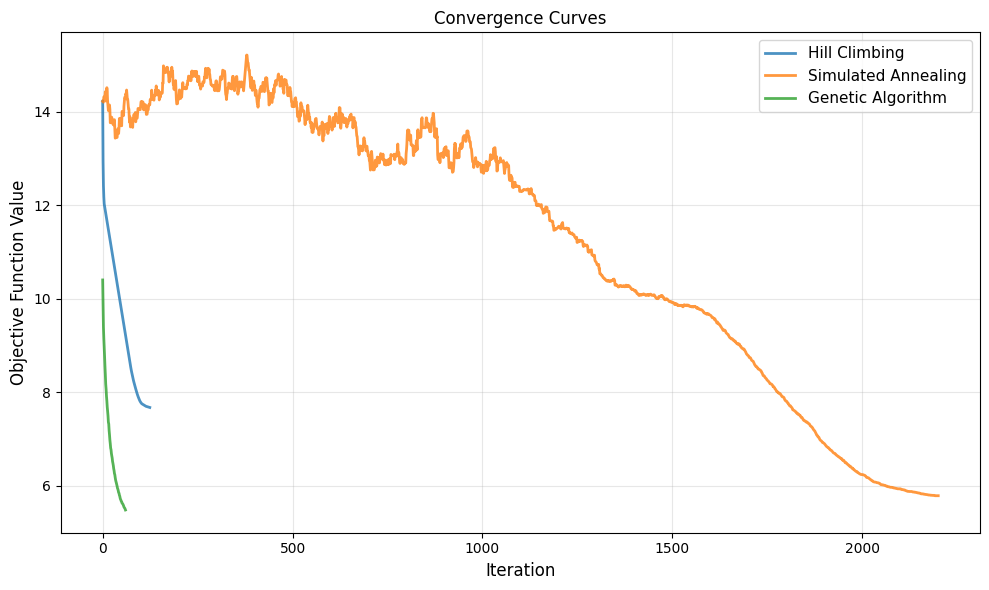

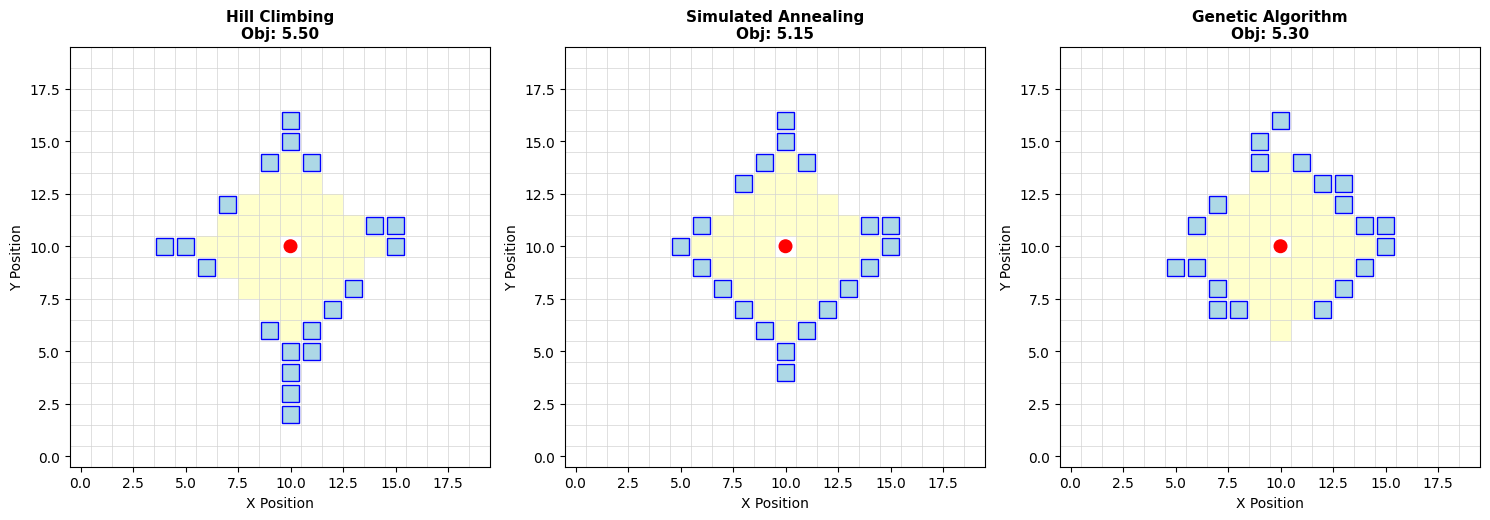


BEST SOLUTIONS FOUND
Hill Climbing: 5.5000
Simulated Annealing: 5.1500
Genetic Algorithm: 5.3000


In [9]:
#Finally, the compare_performance.py script runs all three algorithms on 20 random initial states and collects convergence histories and objective values.

"""Compare local search algorithms on warehouse rack placement optimization."""

# Import Required Libraries
# Import necessary libraries including random, numpy, matplotlib, and custom modules for warehouse optimization.

import random
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

# Note: All required classes are defined in previous cells:
# RackState (cell 3), RackVisualizer (cell 4), HillClimber/SimulatedAnnealing/GeneticAlgorithm (cell 5)

# Run Comparison Across Algorithms
#Define the run_comparison() function that runs all three algorithms (Hill Climbing, Simulated Annealing, Genetic Algorithm) on 20 random initial states and collects convergence histories and objective values.

def run_comparison(num_runs: int = 20, seed: int = 42) -> Dict:
    """
    Run all algorithms on multiple random initial states.
    Args:
        num_runs: Number of random initial states to test.
        seed: Random seed for reproducibility.
    Returns:
        Dictionary with results from all algorithms.
    """
    random.seed(seed)
    np.random.seed(seed)
    results = {
        'hill_climbing': {
            'best_values': [],
            'final_objectives': [],
            'convergence_histories': [],
            'best_state': None,
        },
        'simulated_annealing': {
            'best_values': [],
            'final_objectives': [],
            'convergence_histories': [],
            'best_state': None,
        },
        'genetic_algorithm': {
            'best_values': [],
            'final_objectives': [],
            'convergence_histories': [],
            'best_state': None,
        },
    }
    print(f"Running {num_runs} trials with 3 algorithms...")
    print("-" * 70)
    for trial in range(num_runs):
        # Generate random initial state
        initial_state = RackState()
        # Hill Climbing
        hc = HillClimber(initial_state.copy(), max_iterations=200)
        hc_best, hc_history = hc.optimize()
        results['hill_climbing']['best_values'].append(hc_best.objective_function())
        results['hill_climbing']['convergence_histories'].append(hc_history)
        if (results['hill_climbing']['best_state'] is None or
            hc_best.objective_function() <
            results['hill_climbing']['best_state'].objective_function()):
            results['hill_climbing']['best_state'] = hc_best.copy()
        # Simulated Annealing
        sa = SimulatedAnnealing(initial_state.copy(),
                               initial_temp=250.0,
                               cooling_rate=0.995,
                               max_iterations=2200)
        sa_best, sa_history = sa.optimize()
        results['simulated_annealing']['best_values'].append(sa_best.objective_function())
        results['simulated_annealing']['convergence_histories'].append(sa_history)
        if (results['simulated_annealing']['best_state'] is None or
            sa_best.objective_function() <
            results['simulated_annealing']['best_state'].objective_function()):
            results['simulated_annealing']['best_state'] = sa_best.copy()
        # Genetic Algorithm
        ga = GeneticAlgorithm(population_size=30,
                            mutation_rate=0.2,
                            max_generations=60)
        ga_best, ga_history = ga.optimize()
        results['genetic_algorithm']['best_values'].append(ga_best.objective_function())
        results['genetic_algorithm']['convergence_histories'].append(ga_history)
        if (results['genetic_algorithm']['best_state'] is None or
            ga_best.objective_function() <
            results['genetic_algorithm']['best_state'].objective_function()):
            results['genetic_algorithm']['best_state'] = ga_best.copy()
        if (trial + 1) % 5 == 0:
            print(f"Completed {trial + 1}/{num_runs} trials")
    print("-" * 70)
    return results

# Print Summary Statistics
# Define the print_summary_statistics() function to calculate and display mean, standard deviation, min, and max objective values for each algorithm across all trials.

def print_summary_statistics(results: Dict) -> None:
    """
    Print summary statistics for all algorithms.
    Args:
        results: Results dictionary from run_comparison.
    """
    print("\n" + "=" * 70)
    print("SUMMARY STATISTICS")
    print("=" * 70)
    for algorithm_name, data in results.items():
        best_values = np.array(data['best_values'])
        print(f"\n{algorithm_name.replace('_', ' ').title()}:")
        print(f"  Mean objective value:    {best_values.mean():.4f}")
        print(f"  Std deviation:           {best_values.std():.4f}")
        print(f"  Min (best) objective:    {best_values.min():.4f}")
        print(f"  Max (worst) objective:   {best_values.max():.4f}")
        print(f"  Best solution found:     {data['best_state'].objective_function():.4f}")

# Average Convergence History
# Define the average_convergence_history() function to normalize and average convergence histories across multiple runs by padding shorter histories with their final values.
def average_convergence_history(convergence_histories: List[List[float]]) -> List[float]:
    """
    Average convergence histories, padding shorter ones.
    Args:
        convergence_histories: List of convergence history lists.
    Returns:
        Averaged history.
    """
    max_length = max(len(h) for h in convergence_histories)
    # Pad histories to max length by repeating last value
    padded = []
    for history in convergence_histories:
        if len(history) < max_length:
            padded.append(history + [history[-1]] * (max_length - len(history)))
        else:
            padded.append(history)
    # Average
    return np.mean(padded, axis=0).tolist()

# Execute Performance Comparison
# Call run_comparison() with 20 trials and seed 42, then call print_summary_statistics() to display aggregated performance metrics.
results = run_comparison(num_runs=20, seed=42)
print_summary_statistics(results)

# Plot Convergence Curves
# Prepare averaged convergence histories for each algorithm and use RackVisualizer.plot_convergence() to generate and display convergence curve comparisons.

convergence_data = {
    'Hill Climbing': average_convergence_history(
        results['hill_climbing']['convergence_histories']),
    'Simulated Annealing': average_convergence_history(
        results['simulated_annealing']['convergence_histories']),
    'Genetic Algorithm': average_convergence_history(
        results['genetic_algorithm']['convergence_histories']),
}
# Plot convergence curves
# Prepare averaged convergence histories for each algorithm and use RackVisualizer.plot_convergence() to generate and display convergence curve comparisons.
fig1 = RackVisualizer.plot_convergence(convergence_data, figsize=(10, 6))
plt.draw()

# Plot Best Layouts
# Extract the best solutions from each algorithm and use RackVisualizer.plot_comparison_layouts() to visualize the best rack placements side-by-side.
best_solutions = {
    'Hill Climbing': results['hill_climbing']['best_state'],
    'Simulated Annealing': results['simulated_annealing']['best_state'],
    'Genetic Algorithm': results['genetic_algorithm']['best_state'],
}
fig2 = RackVisualizer.plot_comparison_layouts(best_solutions, figsize=(15, 5))
plt.show()

# Display Results Summary
# Print the best objective values found by each algorithm and confirm that visualizations have been saved.
print("\n" + "=" * 70)
print("BEST SOLUTIONS FOUND")
print("=" * 70)
for algo_name, state in best_solutions.items():
    print(f"{algo_name}: {state.objective_function():.4f}")
